In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re 
from utils import * 
import itertools 
from tqdm import tqdm 
import warnings 
import subprocess
import os 
from src.ggkbase import *
from src.files import *  
import glob
import scipy
import matplotlib as mpl
from scipy.stats import pearsonr 
%load_ext autoreload
%autoreload 2

# NOTE: The MAG annotations in the metadata might be wrong... 
ece_id = 'ece_26_1334'

In [2]:
# How many total spacers do we have?
genome_id_pattern = r'SR-VP_\d{2}_\d{2}_\d{4}_(ck|N)_(top|bottom|middle)([\.|_])(vamb|metabat2|maxbin2|concoct)([\.|_])(\d+)(_sub)*'
get_genome_id = lambda string : re.search(genome_id_pattern, string).group(0).replace('.', '_')

n = sum([fasta_count_sequences(path) for path in glob.glob('../data/spacers/near_cas/*')])
print('Num. sequences in FASTA files:', n)

Num. sequences in FASTA files: 2043


In [3]:
coverm_df = coverm_load()

In [1]:
# def run_spacerblast(database_path:str='../data/blast/databases/ece_26_1334', output_dir:str=blast_output_dir, subject_dir:str='../data/spacers/near_cas/'):
#     query_extension = '.fa'
#     database_name = os.path.basename(database_path)
#     for query_path in tqdm(glob.glob(os.path.join(subject_dir, '*')), desc='run_spacerblast: Searching BLAST target database for spacer hits...'):
#         output_path = os.path.join(output_dir, f'{database_name}-'+ os.path.basename(query_path).replace(query_extension, '.tsv')) 
#         if not os.path.exists(output_path):
#             try:
#                 cmd = f'cctk spacerblast -o {output_path} -d {database_path} -s {query_path}'
#                 subprocess.run(cmd, shell=True, check=True)
#             except:
#                 print(cmd)
#                 print(f'run_spacerblast: Spacerblast failed on {query_path}')

In [ ]:
ce_blast_df = [pd.read_csv(path, sep=r'\s+').assign(query_path=path) for path in glob.glob(f'{blast_output_dir}/ece_26_1334*')]
ece_blast_df = pd.concat(ece_blast_df)
ece_blast_df.columns = ece_blast_df.columns.str.lower()
ece_blast_df = ece_blast_df[ece_blast_df.mismatches <= 1].copy()
# ece_blast_df = ece_blast_df[ece_blast_df.percent_identity > 90].copy()
print('Num. reasonable spacer hits for the ECE:', len(ece_blast_df))

# Several the hits are very short, I wonder if these are the misidentified spacers? In any case, don't really trust them. 


Num. reasonable spacer hits for the ECE: 2


In [7]:
contigs_blast_df = [pd.read_csv(path, sep=r'\s+').assign(query_path=path) for path in glob.glob(f'{blast_output_dir}/contigs*')]
contigs_blast_df = pd.concat(contigs_blast_df)
contigs_blast_df.columns = contigs_blast_df.columns.str.lower()
contigs_blast_df = contigs_blast_df[contigs_blast_df.mismatches <= 1].copy()
print('Num. reasonable spacer hits for the contigs:', len(contigs_blast_df))

Num. reasonable spacer hits for the contigs: 11303


In [8]:
# I think possibly hard to distinguish between self-targeting and organisms having the same spacers. 

min_spacer_length = 25 

contigs_blast_df['host_contig'] = [re.sub(r'_\d+:\d+', '', spacer_id) for spacer_id in contigs_blast_df.spacer_id]
contigs_with_spacers = contigs_blast_df.host_contig.unique()
contigs_blast_df = contigs_blast_df[~contigs_blast_df.target_contig.isin(contigs_with_spacers)].copy()

contigs_blast_df = contigs_blast_df[contigs_blast_df.protospacer_sequence.apply(len) > 25].copy()

remove_target_contigs = ['SR-VP_05_06_2024_N_top_scaffold_173622'] # There is a Cas9 protein on this contig... 
remove_target_contigs += ['SR-VP_05_06_2024_N_top_scaffold_1271'] # Cas protein on this contig too...
remove_target_contigs += ['SR-VP_05_06_2024_ck_bottom_scaffold_1358']

contigs_blast_df = contigs_blast_df[~contigs_blast_df.target_contig.isin(remove_target_contigs)].copy()


In [9]:
metadata_df = load_metadata()
metadata_df = metadata_df[~metadata_df.index.duplicated()].copy()
metadata_df.index = metadata_df.index.str.replace('.', '_', regex=False)

In [ ]:
# ECE aligns to the following contigs:
# SR-VP_05_06_2024_N_bottom_scaffold_6272
# SR-VP_05_06_2024_ck_bottom_scaffold_14226
# SR-VP_05_06_2024_N_middle_scaffold_11254
# SR-VP_05_06_2024_N_top_scaffold_11797

# Only put in a bin in ck_bottom and N_middle, which explains why there are only CRISPR array hits in these samples. My target 
# database only contains sequences from non-unknown bins. 

ece_abundance = dict()
ece_abundance['SR-VP_05_06_2024_N_bottom_scaffold_6272'] = 128.92
ece_abundance['SR-VP_05_06_2024_ck_bottom_scaffold_14226'] = 607.23 
ece_abundance['SSR-VP_05_06_2024_N_middle_scaffold_11254'] =  218.23
ece_abundance['SR-VP_05_06_2024_N_top_scaffold_11797'] = 380.62

# Abundances in the environmental samples...
# Coverage units are already normalized, basically a measure of the average number of times each base is sequenced. 
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_15277'] = 1.98
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_16350'] = 4.2
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_14394'] = 2.07
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_19486'] = 3.31
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_25164'] = 3.32
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_32691'] = 1.89
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_26906'] = 6.82
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_81867'] = 2.96
ece_abundance['SR-VP_11_27_2022_S1_40cm_scaffold_100246'] = 1.05
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_131869'] = 4.42
ece_abundance['SR-VP_11_27_2022_S2_40cm_scaffold_140284'] = 2.73
ece_abundance['SR-VP_11_27_2022_S1_60cm_scaffold_209635'] = 4.68
ece_abundance['SR-VP_11_27_2022_S1_100cm_scaffold_2222'] = 9.49

ece_ids = list(ece_abundance.keys())

organism_info_df = list()
for path in glob.glob('../data/ggkbase/*organism_info.tsv'):
    organism_info_df.append(load_organism_info(path), ids=ece_ids)

organism_info_df = pd.concat(organism_info_df)
organism_info_df = organism_info_df[organism_info_df.coverage > 0].copy()
# organism_info_df[organism_info_df.taxonomy.str.contains('Archaea')]


In [11]:
for row in organism_info_df.itertuples():
    if row.taxonomy == 'none':
        continue
    if row.taxonomy == ece_id:
        continue
    if ('Bacteria' not in row.taxonomy) and ('Archaea' not in row.taxonomy) and ('Borg' not in row.taxonomy):
        print (row)

In [12]:
# fig, ax = plt.subplots(figsize=(4, 4))

# domains = ['Bacteria']
# domains = ['Archaea', 'Borg']

# figure_df = organism_info_df.copy()
# figure_df = figure_df.sort_values('metagenome_id')
# figure_df['domain'] = [re.search('Archaea|Bacteria|ece_26_1334|Borg|none', taxonomy).group(0) for taxonomy in figure_df.taxonomy]
# print('Num. elements with no assigned domain:', (figure_df.domain != 'none').sum())
# figure_df = figure_df[figure_df.domain != 'none'].copy()
# figure_df.to_csv('sandbox-3_figure-1.csv')

# if domains is not None:
#     figure_df = figure_df[figure_df.domain.isin(domains + [ece_id])].copy()

# sns.stripplot(figure_df[figure_df.taxonomy != ece_id], x='metagenome_id', y='normalized_coverage', hue='domain', palette='Grays')
# sns.stripplot(figure_df[figure_df.taxonomy == ece_id], x='metagenome_id', y='normalized_coverage', color='indianred', linewidth=0.7, edgecolor='black')
# sns.stripplot(figure_df[figure_df.taxonomy.str.contains('Methanoperedens')], x='metagenome_id', y='normalized_coverage', color='steelblue', linewidth=0.7, edgecolor='black')
# ax.set_xticks(ax.get_xticks(), labels=ax.get_xticklabels(), rotation=90)
# ax.set_xlabel('')
# ax.set_ylabel('normalized coverage (CLR)')
# plt.show()

In [13]:
def label_samples(figure_df, sample_names:list=[], ax=None, x_column='rpkm', y_column='coverm_rpkm'):
    for row in figure_df[figure_df.sample_name.isin(sample_names)].itertuples():
        x, y = getattr(row, x_column), getattr(row, y_column)
        ax.text(x, y, row.sample_name, fontsize='x-small', fontweight='bold')

figure: Slope of best-fit line: 8.258605376523166
figure: Intercept of best-fit line: 1.215881746658725


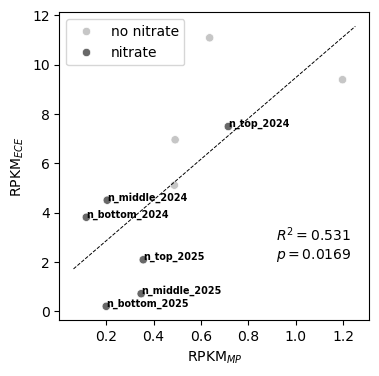

In [27]:
# I think I should be log-normalizing when comparing coverage, as the R-squared value assumes normal distribution, but coverage
# is often log-normally distributed.

environmental_sample_names = coverm_df[~coverm_df.sample_name.str.match('n_.*|ck_.*')].sample_name.unique()

def figure(coverm_df:pd.DataFrame, exclude_samples:list=[], legend_loc='lower right', log_scale:bool=True):
    figure_df = coverm_df.copy()
    figure_df = figure_df[~figure_df.sample_name.isin(exclude_samples)].copy()
    figure_df = figure_df.pivot(columns='target_name', values='rpkm', index='sample_name')
    if log_scale:
        figure_df = np.log(figure_df) # Log-normalize the coverage values. 
    figure_df['sample_name'] = figure_df.index
    
    figure_df['category'] = np.select([figure_df.sample_name.str.match(r'\d+(cm|m)_\d+'), figure_df.sample_name.str.startswith('n_')], ['environment', 'nitrate'], default='no nitrate')
    
    fig, ax = plt.subplots(figsize=(4, 4), ncols=1)
    sns.scatterplot(figure_df, x=mp_id, y=ece_id, ax=ax, hue='category', palette='Grays')
    ax.legend().set_title('')

    y, x = figure_df[ece_id].values, figure_df['methanoperedens_2'].values 
    result = pearsonr(x, y, alternative='two-sided')
    m, b = np.polyfit(x, y, 1)
    print('figure: Slope of best-fit line:', m)
    print('figure: Intercept of best-fit line:', b)

    r = result.statistic
    p = result.pvalue 

    x_min, x_max = ax.get_xlim()
    sns.lineplot(x=np.linspace(x_min, x_max, 10), y=np.linspace(x_min, x_max, 10) * m + b, ls='--', color='black', lw=0.7)
    ax.text(0.7, 0.2, f'$R^2=$' + f'{r ** 2:.3f}\n' + f'$p={p:.4f}$', transform=ax.transAxes)

    ax.set_xlabel('log(RPKM$_{MP}$)' if log_scale else 'RPKM$_{MP}$')
    ax.set_ylabel('log(RPKM$_{ECE}$)' if log_scale else 'RPKM$_{ECE}$')
    sns.move_legend(ax, loc=legend_loc)

    sample_names = ['n_bottom_2025', 'n_middle_2025','n_top_2024', 'n_bottom_2024', 'n_middle_2024', 'n_top_2025']
    # sample_names += ['ck_bottom_2025', 'ck_middle_2025','ck_top_2025']
    label_samples(figure_df, sample_names=sample_names, ax=ax, y_column=ece_id, x_column=mp_id)
    # ax.set_aspect('equal')
    plt.show()

    return figure_df

# figure_df = figure(coverm_df, exclude_samples=environmental_sample_names)
exclude_samples_not_n_2025 = [sample_name for sample_name in coverm_df.sample_name.unique() if (sample_name not in ['n_top_2025', 'n_middle_2025', 'n_bottom_2025'])]
exclude_samples_not_n_2024 = [sample_name for sample_name in coverm_df.sample_name.unique() if (sample_name not in ['n_top_2024', 'n_middle_2024', 'n_bottom_2024'])]
# figure_df = figure(coverm_df, exclude_samples=exclude_samples_not_n_2025, legend_loc='upper left', log_scale=True) 
figure_df = figure(coverm_df, exclude_samples=environmental_sample_names, legend_loc='upper left', log_scale=False) 
# figure_df = figure(coverm_df, exclude_samples=['n_top_2025', 'n_middle_2025', 'n_bottom_2025'], legend_loc='upper left')


In [26]:
mask = figure_df.sample_name.isin(['n_top_2025', 'n_middle_2025', 'n_bottom_2025'])
print('Mean ECE vs. Methanoperedens ratio (RPKM) in nitrate-rich 2025 samples:', (figure_df[mask][ece_id] / figure_df[mask][mp_id]).mean())
mask = figure_df.sample_name.isin(['n_top_2024', 'n_middle_2024', 'n_bottom_2024'])
print('Mean ECE vs. Methanoperedens ratio (RPKM) in nitrate-rich 2024 samples:', (figure_df[mask][ece_id] / figure_df[mask][mp_id]).mean())


Mean ECE vs. Methanoperedens ratio (RPKM) in nitrate-rich 2025 samples: 2.998907934452678
Mean ECE vs. Methanoperedens ratio (RPKM) in nitrate-rich 2024 samples: 21.843888453410184


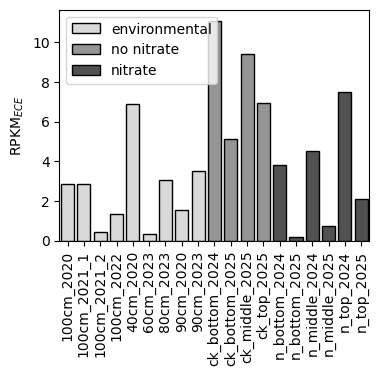

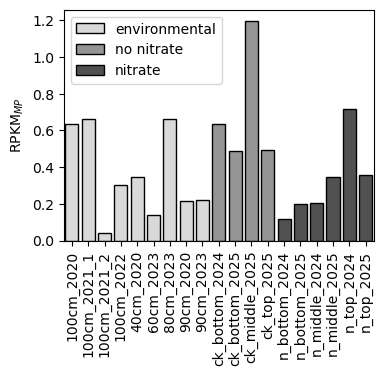

In [ ]:
# Because the host is not confirmed, and there may be multiple similar hosts, the ratio might not be super informative. 

# figure_df = coverm_df.groupby(['sample_name', 'target_name']).apply(lambda df : (df['trimmed_mean'] * df.contig_size / df.contig_size.sum()).sum(), include_groups=False)
# figure_df = figure_df.reset_index(name='coverage')
# figure_df = figure_df.pivot(columns='target_name', values='coverage', index='sample_name')
# figure_df['category'] = np.select([figure_df.index.str.match(r'\d+(cm|m)_\d+'), figure_df.index.str.startswith('n_')], ['environmental', 'nitrate'], default='no nitrate')
# figure_df['ratio'] = figure_df.ece_26_1334 / figure_df.methanoperedens_2
# figure_df['sample_name'] = figure_df.index

# NOTE: Seemed to see an increase in ECE transcriptional activity in no-nitrate conditions relative to the activity of the host. 
# However, this may not be reliable in the event that there are multiple hosts. 

def figure(coverm_df:pd.DataFrame, target_name:str=ece_id):

    # figure_df = figure_df[figure_df.category != 'environmental'].copy()
    target_name_map = {ece_id:'ECE', mp_id:'MP'}

    figure_df = coverm_df[coverm_df.target_name == target_name].copy()
    figure_df['category'] = np.select([figure_df.sample_name.str.match(r'\d+(cm|m)_\d+'), figure_df.sample_name.str.startswith('n_')], ['environmental', 'nitrate'], default='no nitrate')
    figure_df['rpkm'] = figure_df.rpkm

    fig, ax = plt.subplots(figsize=(4, 3), ncols=1)
    sns.barplot(figure_df.sort_values('sample_name'), x='sample_name', y='rpkm', ax=ax, hue='category', palette='Grays', edgecolor='black')
    # sns.barplot(figure_df, x='sample_name', y='ratio', ax=ax, color='lightgray', edgecolor='black')
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=90)
    ax.set_xlabel('')
    ax.set_ylabel('log(RPKM$_{' + target_name_map[target_name] + '}$)')
    ax.set_ylabel('RPKM$_{' + target_name_map[target_name] + '}$')
    ax.legend().set_title('')

    plt.show()


figure(coverm_df)
figure(coverm_df, target_name='methanoperedens_2')

# Methanoperedens is generally slightly more abundant in 2025. 

In [17]:
# # figure_df = coverm_df.groupby(['sample_name', 'target_name']).rpkm.sum().reset_index()
# figure_df = coverm_df.groupby(['sample_name', 'target_name']).apply(lambda df : (df['mean'] * df.contig_size / df.contig_size.sum()).sum(), include_groups=False)
# figure_df = figure_df.reset_index(name='coverage')
# figure_df = figure_df.pivot(columns='target_name', values='coverage', index='sample_name')
# figure_df['category'] = np.select([figure_df.index.str.match(r'\d+(cm|m)_\d+'), figure_df.index.str.startswith('N_')], ['environmental', 'nitrate'], default='no nitrate')
# fig, ax = plt.subplots(figsize=(4, 4), ncols=1)
# sns.scatterplot(figure_df, x=ece_id, y='methanoperedens_2', ax=ax, hue='category', palette='Grays')
# ax.legend().set_title('')
# plt.show()

In [18]:
# ece_seq = FASTAFile.from_file(f'../data/{ece_id}.fn').seqs[0]
# ece_df = GenBankFile.from_file(f'../data/{ece_id}.gbk').to_df()

# coordinate_pattern = r'(\d+)..(\d+)'
# ece_df['start'] = [int(re.search(coordinate_pattern, coordinate).group(1)) for coordinate in ece_df.coordinate]
# ece_df['stop'] = [int(re.search(coordinate_pattern, coordinate).group(2)) for coordinate in ece_df.coordinate]
# ece_df['stop_codon'] = [ece_seq[stop - 3:stop] for stop in ece_df.stop]
# ece_df['strand'] = np.where(ece_df.coordinate.str.contains('comp'), '-', '+')

# ece_df['nt_seq'] = [ece_seq[start:stop] for start, stop in zip(ece_df.start, ece_df.stop)]
# ece_df['nt_seq'] = [reverse_complement(row.nt_seq) if (row.strand == '-') else row.nt_seq for row in ece_df.itertuples()] # Reverse complement if on the opposite strand. 

In [19]:
# has_cas = False

# fig, ax = plt.subplots(figsize=(4, 4))

# figure_df = blast_df.copy()
# figure_df = figure_df[figure_df.query_domain != 'none'].copy()
# if has_cas:
#     figure_df = figure_df[figure_df.has_cas].copy()

# sns.ecdfplot(figure_df, x='percent_identity', hue='query_domain', palette='Grays')

# legend = ax.get_legend()
# handles = legend.get_lines()
# labels = [label.get_text() for label in legend.get_texts()][:2]
# # labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
# labels = [f'{domain} (n={(figure_df.query_domain == domain).sum()})' for domain in labels]
# ax.legend(handles, labels, title='putative host domain')

# ax.set_ylabel('proportion')
# ax.xaxis.set_major_formatter(mpl.ticker.PercentFormatter())
# ax.set_xlabel('identity to spacer')

# plt.show()